This file will combine the previously created ESNN and basal ganglia architectures in a complete loop

In [2]:
#importing libraries....
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.sparse.linalg import eigs
from matplotlib.animation import FuncAnimation


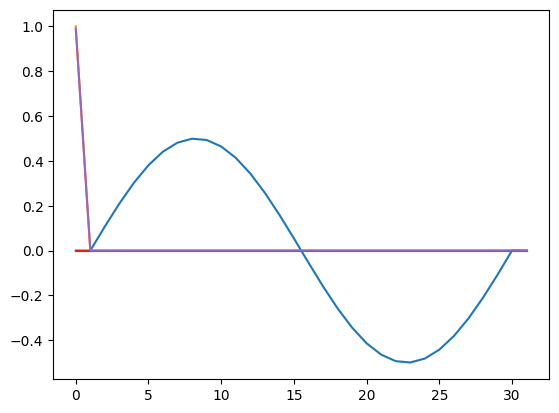

In [91]:
###regiment 5, two sines waves of different period, not concatenated together. #####################################################################################################################################################

input1 = np.zeros((52,2))
input1[1,1] = 1
input1[1,0] = 1


output1=np.zeros((52,1))


wave1 = np.sin(np.linspace(0,np.pi*2,50))*0.5

for i in range(50):
    output1[i+1,0] = wave1[i]

output1[50] = 0.001

input2 = np.zeros((42,2))
input2[1,1] = 2
input2[1,0] = 1


output2=np.zeros((42,1))


wave2 = np.sin(np.linspace(0,np.pi*2,40))*0.5

for i in range(40):
    output2[i+1,0] = wave2[i]

output2[40] = 0.001

inputs5 = [input1, input2]
outputs5 = [output1, output2]

### regiment 6, three sine waves of different periods, set up st. the ESNN can be merged with the basal ganglia component
input1 = np.zeros((52,4))
input1[0,0] = 1
input1[0,1] = 0.988
output1=np.zeros((52,1))
wave1 = np.sin(np.linspace(0,np.pi*2,50))*0.5
for i in range(50):
    output1[i+1,0] = wave1[i]
output1[50] = 0.001

input2 = np.zeros((42,4))
input2[0,0] = 1
input2[0,2] = 0.988
output2=np.zeros((42,1))
wave2 = np.sin(np.linspace(0,np.pi*2,40))*0.5
for i in range(40):
    output2[i+1,0] = wave2[i]
output2[40] = 0.001

input3 = np.zeros((32,4))
input3[0,0] = 1
input3[0,3] = 0.988
output3=np.zeros((32,1))
wave2 = np.sin(np.linspace(0,np.pi*2,30))*0.5
for i in range(30):
    output3[i+1,0] = wave2[i]
output3[30] = 0.001

inputs6 = [input1, input2, input3]
outputs6 = [output1, output2, output3]


plt.plot(output3)
plt.plot(input3)




In [140]:
class b_ganglia:
    def __init__(self,n_loops,time_steps):

        self.n_loops=n_loops

        #activations for all units
        self.a_sd1 = np.zeros((time_steps, n_loops))
        self.a_sd2 = np.zeros((time_steps, n_loops))
        self.a_stn = np.zeros((time_steps, n_loops))
        self.a_gpi = np.ones((time_steps, n_loops))
        self.a_gpe = np.zeros((time_steps, n_loops))
        self.a_tha = np.zeros((time_steps, n_loops))
        self.a_ctx = np.zeros((time_steps, n_loops))

        #vector to hold changing dopamine levels
        self.da = np.ones((time_steps))

        #vector to hold the inputs...
        self.a_inp = np.ones((time_steps, n_loops)) * 0.05


        #variable to keep track of what step we are currently on
        self.c = 0




    #uses euler integration to calculate the activation at each unit in the model of the basal ganglia 
    def step(self, i):

        #likely easier to just define the parameters inside this function...
        
        dt = 0.001
        tau = 0.01
        #time constant 
        h= dt/tau

        #define the weight matrices
        #define the weight matrices
        w_inp_sd1 = np.array([[1,0,0],[0,1,0],[0,0,1]]) * 8
        w_inp_sd2 = np.array([[1,0,0],[0,1,0],[0,0,1]]) * 8
        w_ctx_sd1 = np.array([[1,0,0],[0,1,0],[0,0,1]]) * 12
        w_ctx_sd2 = np.array([[1,0,0],[0,1,0],[0,0,1]]) * 12
        w_ctx_stn = np.array([[1,0,0],[0,1,0],[0,0,1]]) * 12 
        w_sd1_gpi = np.array([[1,0,0],[0,1,0],[0,0,1]]) * -25 
        w_sd2_gpe = np.array([[1,0,0],[0,1,0],[0,0,1]]) * -15
        w_stn_gpi = np.ones((self.n_loops,self.n_loops)) * 10
        w_stn_gpe = np.ones((self.n_loops,self.n_loops)) * 2
        w_gpe_stn = np.array([[1,0,0],[0,1,0],[0,0,1]]) * -13
        w_gpe_gpi = np.array([[1,0,0],[0,1,0],[0,0,1]]) * -4
        w_gpi_tha = np.array([[1,0,0],[0,1,0],[0,0,1]]) * -45
        w_tha_ctx = np.array([[1,0,0],[0,1,0],[0,0,1]]) * 40 


        #define the sensitivies to dopamine and normal response
        sd1_bl = 0.1
        sd1_DA = 0.9
        sd2_bl = 1
        sd2_DA = 10
        gpi_bl = 0.1
        gpe_bl = 0.1
        

        #input to sd1 from cortex modulated by dopamine, this completes the loop
        self.a_sd1[i+1] = self.non_lin(h * (-1 * self.a_sd1[i] + (sd1_bl + sd1_DA * self.da[i]) * (np.matmul(self.a_ctx[i], w_ctx_sd1)+ np.matmul(self.a_inp[i], w_inp_sd1))))

        #input to sd2 modulated by dopamine
        self.a_sd2[i+1] = self.non_lin(h * (-1 * self.a_sd2[i] + (1/(sd2_bl + sd2_DA * self.da[i])) * ((np.matmul(self.a_ctx[i], w_ctx_sd2))+ np.matmul(self.a_inp[i], w_inp_sd2)))) 

        #input to stn from ctx and gpe
        self.a_stn[i+1] = self.non_lin(h * (-1 * self.a_stn[i] + (np.matmul(self.a_ctx[i], w_ctx_stn)) + np.matmul(self.a_gpe[i], w_gpe_stn)+9))

        #input to gpe from stn and sd2
        self.a_gpe[i+1] = self.non_lin(h * (-1 * self.a_gpe[i] + (np.matmul(self.a_sd2[i], w_sd2_gpe)) + (np.matmul(self.a_stn[i], w_stn_gpe)) + 8 ))

        #input to gpi from strd1, stn, and gpe 
        self.a_gpi[i+1] = self.non_lin(h * (-1 * self.a_gpi[i] + (np.matmul(self.a_sd1[i], w_sd1_gpi))+ (np.matmul(self.a_stn[i], w_stn_gpi)) + (np.matmul(self.a_gpe[i], w_gpe_gpi))+10))

        #input to thalamus from gpi 
        self.a_tha[i+1] = self.non_lin(h * (-1 * self.a_gpi[i] + (np.matmul(self.a_gpi[i], w_gpi_tha))+ 8))

        #input to cortex from gpi, also going to give some tonic excitation
        self.a_ctx[i+1] = self.non_lin(h * (-1 * self.a_ctx[i] + (np.matmul(self.a_tha[i], w_tha_ctx))))


        
        self.c += 1

        return None

    #non-linearity to generate activations
    def non_lin(self,vec):

        #apply non-linearity
        x = np.tanh(1*(vec)+0)
        
        #set any negative values to 0
        for i in range(self.n_loops):
            if x[i] < 0:
                x[i] = 0
        
        return x

    def run(self, steps):
        

        for i in range(5):
            self.a_inp[i+15] =  [0.3,0.55,0.2]
            self.a_inp[i+75] =  [0.55,0.3,0.2]

        self.a_inp[30:35] = [0.05,0.05,0.55]
        self.a_inp[90:95] = [0.05,0.05,0.55]

        self.da[40:70] = 0

        for i in range(steps):
            self.step(i=self.c)

        

    def display(self):
        fig, axs = plt.subplots(9)
        fig.set_figheight(20)
        fig.set_figwidth(15)

        #input
        axs[0].plot(self.a_inp)
        axs[0].set_title('Input')

        #input
        axs[1].plot(self.da)
        axs[1].set_title('DA')

        #Sd1
        axs[2].plot(self.a_sd1)
        axs[2].set_title('SD1')

        #Sd2
        axs[3].plot(self.a_sd2)
        axs[3].set_title('SD2')

        #STR
        axs[4].plot(self.a_stn)
        axs[4].set_title('STN')

        #GPi
        axs[5].plot(self.a_gpi)
        axs[5].set_title('GPi')

        #GPe
        axs[6].plot(self.a_gpe)
        axs[6].set_title('GPe')
 
        #Tha
        axs[7].plot(self.a_tha)
        axs[7].set_title('THA')

        #Tha
        axs[8].plot(self.a_ctx)
        axs[8].set_title('CTX')
        return None


class ESNN:
    def __init__(self, n_input, n_internal, n_output,spectralRadius=1,inputScaling=1,inputShift=0,outputActivationFunction="tanh",noise_level=0, teacherScaling=1, learningMode = "offline_singleTimeSeries", teacherShift=0.0,methodWeightCompute="pseudoinverse", connectivityScale = 1, network_type = "plain", atime_constant=1,ltime_constant=1, leakage=0):
        import numpy as np

        #initialize hyperparameters
        self.n_input = n_input
        self.n_internal = n_internal
        self.n_output = n_output
        self.n_total = n_input + n_internal + n_output
        #how much are we shifting/scaling the input signal
        self.inputScaling = inputScaling
        self.inputShift = inputShift
        #how much are we shifting/scaling the teacher signal
        self.teacherScaling = teacherScaling
        self.teacherShift = teacherShift
        #spectral radius controls the magnitude of the values in the internal connectivity matrix
        self.spectralRadius = spectralRadius
        self.noise_level = noise_level
        #how are we normalizing outputs to [0,1]
        self.outputActivationFunction = outputActivationFunction
        self.learningMode = learningMode
        #what algorithm are we using to compute the output weights
        self.methodWeightCompute = methodWeightCompute
        self.internalstore = 0
        #are the units in the network leaky or not?
        self.network_type = network_type

        #these are important if leaky
        self.atime_constant = atime_constant
        self.ltime_constant = ltime_constant
        self.leakage = leakage 

        #intialize hidden weight matrix density
    
        self.connectivity = min([10/n_internal,1]) * connectivityScale

        #generate input weight matrix
        self.W_input = 2 * np.random.rand(n_internal, n_input) - 1 
        #generate internal weight matrix
        self.W_internal = self.gen_W_internal(self.n_internal, self.connectivity)
        #generate output weights, original code included input-output connections, lets skip those
        self.W_output = 2 * np.random.rand(n_output, n_internal) - 1 
        #these are the "feedback" weights from output to internal, setting to zero for now, only keeping in code to maintain similar structure as original
        self.W_feedback = np.zeros((n_internal, n_output))
        #self.W_feedback = 2 * np.random.rand(n_internal, n_output) - 1 

        #using this method because I cannot program properly...
        self.statemat = []



    #this function will act to plot the internal activation before training the network, to save time, no waiting for other computations
    def w_check(self, input):
        
        #just determine internal activities caused by each pulse, then plot them to make sure we are getting appropriate decay
        for pulse in input:
            mat = self.compute_statematrix(inputSequence=pulse,outputSequence=[],nForgetPoints=0)
            mean_activity = np.mean(mat,axis=1)
            plt.plot(mean_activity, alpha=0.5)
        

        return None

    #the non-linearity that all the unit activity is being fed through
    #since we are using the ESNN as a model of the cortex, all activity must be restricted to be above 0, it will just be a hyperbolic tan function shifted upwards
    def non_lin(self,activations):

        filtered = np.tanh(4*(activations-0.5)) + 1
        
        ## MAKE SURE THAT THIS FUNCTION IS IN LINE WITH THE INVERSE NON-LIN FUNCTION OR ELSE THIS WHOLE THING BREAKS
        return filtered
    
    #in the learning protocal we need to undo the non-linearity to see what the activation should be, this function performs that
    def inverse_non_lin(self,filtered):

        unfiltered = 0.25 * np.arctanh(filtered-1)+0.5
        return unfiltered 


    #get this checked next to the matlab code
    #this function creates the random internal weight matrix
    def gen_W_internal(self, n_internal, connectivity):
        #import libraries (get this fixed)
        from scipy.sparse.linalg import eigs
        import scipy.sparse as sparse
        #generate randomly distributed sparese n_internal x n_internal matrix 
        W_internal = sparse.rand(n_internal, n_internal,density=connectivity,format="coo")
        #find the maximum eigenvalue of said matrix
        maxval = max(abs(eigs(W_internal, return_eigenvectors=False,k=1,which="LM")))
        #transform into an array form (some weird scipy thing i guess)
        W_internal = W_internal.toarray()

        #center mean of entries at 0, ensure we have negative values to yield echoes
        W_internal = np.where(W_internal>0, W_internal - 0.5, W_internal)

        #normalize the weight matrix by dividing by the largest eigenvalue, then multiple by the selected spectral radius
        return np.array(self.spectralRadius * W_internal / maxval)
    
    #inputSequence is nTrainingPoints x nInputDim
    #outputSequence is nTrainingPoints x nOutputDim
    #nForgetPoints is the number of initial data points we wash out to avoid initial transients
    def compute_statematrix(self,inputSequence,outputSequence=[],nForgetPoints=0):  
        import numpy as np
        #if there is no supplied output sequence, the ESNN is assumed to be in testing, as opposed to training
        if len(outputSequence) == 0:
            teacherForcing = 0
            nDataPoints = len(inputSequence[:,0])
        else:
            teacherForcing = 1
            nDataPoints = len(inputSequence[:,0])


        #define the "state collection matrix", contains all activity of the input as well as internal units
        if nForgetPoints > 0:
            stateCollectMat = np.zeros((nDataPoints - nForgetPoints, self.n_internal))
        else:
            stateCollectMat = np.zeros((nDataPoints, self.n_internal))

        ### I am ignoring the section of code about giving the network a starting state before input

        #matrices holding the activity of all units and internal units?
        totalstate = np.zeros(self.n_total) #note the units appear in this matrice in order of [internal, input, output], idk why blame jaeger
        internalstate = self.non_lin(np.zeros(self.n_internal))

        collectIndex = 0
        for i in range(0,nDataPoints):
            #shift and scale input activation by predefined values
            a_input = inputSequence[i,:] * self.inputScaling + self.inputShift
            #write this input signal into the totalstate matrix
            totalstate[self.n_internal:self.n_input+self.n_internal] = a_input

            #combine all weight matrices into one so matmul works
            W_concatenate = np.concatenate((self.W_internal, self.W_input, self.W_feedback),axis=1)
            #calculate internal state based on activity of all units, sent through a hyperbolic function to keep below 0
            #add uniformly distributed noise
            if self.network_type == "plain":
                internalstate = self.non_lin(np.matmul(W_concatenate,  totalstate)) + np.random.uniform(-1,1,self.n_internal) * self.noise_level
            if self.network_type == "leaky":
                #grab the activity of the internal units last time step
                previous_internalstate = totalstate[0:self.n_internal] 
                #first calculate how much the previous state has decayed, then add the activity resulting from all inputs
                internalstate = (1 - self.leakage * self.ltime_constant) * previous_internalstate + self.atime_constant * self.non_lin(np.matmul(W_concatenate,  totalstate))
                #add noise 
                internalstate = internalstate + np.random.uniform(-1,1,self.n_internal) * self.noise_level

            #if we are forcing output, the output is set as the predefined signal
            #otherwise we calculate it based on internal unit activity
            if teacherForcing == 1: 
                netOut = self.teacherScaling * outputSequence[i,:] + self.teacherShift
            else:
                netOut = np.tanh(np.matmul(self.W_output, internalstate ))

            #put all the unit activities together in a array of form [internal units, input units, output units]
            totalstate = np.concatenate((internalstate, a_input, netOut))                

            #put all of our input and internal activities into a matrix that contains all their behaviour over time
            #we are ignoring the first nForgetPoints entries
            if i >= nForgetPoints:
                stateCollectMat[collectIndex,:] = internalstate
                collectIndex += 1
            
            if len(self.statemat)==0:
                self.statemat = stateCollectMat

        return stateCollectMat
    
    
    #this function takes in a input and desired produced output, as well as the number of initial activity points that should be ignored while calculating the statematrix (these may be a problem)
    def train(self, trainInput, trainOuput, nForgetPoints=0):
        
        #allowing myself to add other training modes later if i want
        if self.learningMode == "offline_singleTimeSeries":
            #computes the activity of the internal units due to input and feedback activity
            stateCollection = self.compute_statematrix(inputSequence=trainInput, outputSequence=trainOuput,nForgetPoints=nForgetPoints)
            #calculates what the input to the output units should be, "unsquashes" them
            teacherCollection = self.compute_teacher(outputSequence=trainOuput, nForgetPoints=nForgetPoints)
            #actually trains the output weights 
            self.W_output = self.train_Woutput(stateCollection,teacherCollection)

            self.imean_activity = np.mean(self.statemat,axis=1)

        #this is going to be using the training method inspired by the one outlined in the Baldassarre paper, just concatanating multiple state matrice's together
        if self.learningMode == "Baldassarre":
            #this is a concatenation of all the input sequences
            collectedStates = np.zeros((0,self.n_internal))
            #this is a concatenation of all the output sequences
            collectedTeachers = np.zeros((0,self.n_output))

            for i in range(len(trainInput)):
                #compute the internal activations for the current input/output pair
                state_mat =  self.compute_statematrix(inputSequence=trainInput[i], outputSequence=trainOuput[i],nForgetPoints=nForgetPoints)
                #add this to the collection of state matrices
                collectedStates = np.concatenate((collectedStates,state_mat))

                #compute the unsquashed training output activation
                teacher_mat = self.compute_teacher(outputSequence=trainOuput[i], nForgetPoints=nForgetPoints)
                collectedTeachers = np.concatenate((collectedTeachers,teacher_mat))

            self.W_output = self.train_Woutput(collectedStates,collectedTeachers)

        

        return None

    #scales, shifts, and applies the inverse output activation function on the expected teacher
    def compute_teacher(self,outputSequence,nForgetPoints):
        import numpy as np

        nOutputPoints = len(outputSequence[:,0])
        teachCollectMat = np.zeros((nOutputPoints-max([0,nForgetPoints]),self.n_output))

        #remove the first nForgetPoints from the output sequence
        if nForgetPoints > 0:
            outputSequence = outputSequence[nForgetPoints:,:]

        #update the number of point (I'm just doing what Jaeger did dont blame me)
        nOutputPoints = len(outputSequence[:,0])

        #compare this to matlab code as well, no idea whats happening
        #i think this is just shifting/scaling the output, whatever that means
        teachCollectMat = self.teacherScaling * outputSequence + self.teacherShift

        #calculate what the corresponding input to the output units should be, essentially undo tanh squashing
        teachCollectMat=np.arctanh(teachCollectMat)

        return teachCollectMat
    
    #this function actually calculates the new output weights
    def train_Woutput(self, stateCollectMat, teacherCollectMat,):
        import numpy
        
        #allowing the training method to be specified in case I want to add more later
        #i have no clue wtf the wiener-hopf method is, this is my best attempt to replicate the matlab code exactly
        if self.methodWeightCompute == "wiener_hopf":
            runlength = len(stateCollectMat[:,0])
            covMat = np.matmul(np.transpose(stateCollectMat),stateCollectMat)/runlength
            pVec = np.matmul(np.transpose(stateCollectMat), teacherCollectMat)/runlength
            outputWeights = np.matmul(np.linalg.inv(covMat),pVec)

        #this is another training method ripped from the matlab code
        if self.methodWeightCompute == "pseudoinverse":
            stateCollectMat = np.linalg.pinv(stateCollectMat)
            outputWeights = np.matmul(stateCollectMat,teacherCollectMat)
        
        else:
            print("invalid methodWeightCompute value")


        return outputWeights
    
    #this function will determine how closely the network can replicate the desired output
    def evaluate(self, inputSequence, outputSequence,nForgetPoints=0):
        import numpy
        import matplotlib.pyplot as plt
        #generate the expected output of the network
        #determine activity of internal and input units
        a_internal = self.compute_statematrix(inputSequence=inputSequence, outputSequence=outputSequence, nForgetPoints=nForgetPoints)
        #matrix multiply with trained output weights
        predictedTrainOutput = np.concatenate(np.tanh(np.matmul(a_internal,self.W_output)))

        #remove the shifting and scaling (probably useless)
        predictedTrainOutput = (predictedTrainOutput - self.teacherShift)/self.teacherScaling

        meanerror, error = self.compute_error(predictedTrainOutput,outputSequence,nForgetPoints)

        print("mean square error=", meanerror, "error=", error)

        #graph our expected and observed signals
        y = len(predictedTrainOutput)

        mean_activity = numpy.mean(self.statemat,axis=1)

        plt.plot(predictedTrainOutput, label="Observed Signal", color="red",alpha = 0.5)
        plt.plot(outputSequence,label="Training Data",color="blue", alpha=0.5)
        plt.plot(inputSequence,label="Input Sequence", color="green",alpha=0.5)
        plt.plot(mean_activity,label="Mean Unit Activty", color="darkviolet",alpha=0.5)

        plt.legend()

        print("mean activity=",mean_activity[75:80])

        return None 

    #this function may not work for outputs containing for than one unit (hopefully not a problem)
    def compute_error(self, observed, expected, nForgetPoints):

        #how long is our real output
        nEstimatePoints = len(observed)

        nForgetPoints = len(expected[:,0]) - nEstimatePoints

        expected = expected[nForgetPoints:]

        #three lines above this only relavant if nForgetPoints>0, not sure if this will ever happen

        meanerror = np.sum(np.square(expected - observed)) / nEstimatePoints 
        error = (np.sqrt(meanerror/np.var(expected)))
        
        return meanerror, error 
    
    def display_units(self):
        fig, axs = plt.subplots(4, 5)
        storage = []
        for i in range(4):
            for j in range(5):
                passing = False
                while passing == False:
                    k = np.random.randint(len(self.statemat[0]))
                    if storage.count(k)==0:
                        storage.append(k)
                        axs[i,j].plot(self.statemat[:,k],color = "darkviolet",alpha=0.5 )
                        passing = True
        
        for ax in axs.flat:
            ax.set(xlabel='time', ylabel='activity')
        for ax in axs.flat:
            ax.label_outer()

        return None

    #going off of the pre-exhisting code from compute_statematrix, we will have the ESNN generate its own input based on when its produced sine wave finishes a cycle
    #will require specially constructed input sequences
    #probably always keep nForgetPoints = 0, i have never tested it so it probably doesn't work, it was in Jaeger's code so I moved it over 
    def live_run(self,time_points=0):  
        import numpy as np

        #initilize the basal ganglia within this run
        bg = b_ganglia(3,time_points+1)
        #give it some input
        bg.a_inp[15:20] = [0.3,0.55,0.2]

        #define the input vector for the ESNN, empty as of now
        inputSequence = np.zeros((time_points, 4))
    
        outputSequence = []
        nForgetPoints = 0
        
        #if there is no supplied output sequence, the ESNN is assumed to be in testing, as opposed to training
        if len(outputSequence) == 0:
            teacherForcing = 0
            nDataPoints = len(inputSequence[:,0])
        else:
            teacherForcing = 1
            nDataPoints = len(inputSequence[:,0])


        #define the "state collection matrix", contains all activity of the input as well as internal units
        if nForgetPoints > 0:
            stateCollectMat = np.zeros((nDataPoints - nForgetPoints, self.n_internal))
        else:
            stateCollectMat = np.zeros((nDataPoints, self.n_internal))

        outputCollectMat = np.zeros((nDataPoints, self.n_output))

        ### I am ignoring the section of code about giving the network a starting state before input

        #matrices holding the activity of all units and internal units?
        totalstate = np.zeros(self.n_total) #note the units appear in this matrice in order of [internal, input, output], idk why blame jaeger
        internalstate = self.non_lin(np.zeros(self.n_internal))

        collectIndex = 0
        spike_count = 1


        #define the refractory period
        r_per = 25
        r_count = 25
        cstep = 0
        for i in range(0,nDataPoints):
        
            bg.step(cstep)

            if cstep == 35:
                print(bg.a_ctx[cstep])
                inputSequence[i+1] = np.concatenate([[1],np.round(bg.a_ctx[cstep],3)]) 
                totalstate[0:self.n_internal] = self.non_lin(np.zeros(self.n_internal))

            #shift and scale input activation by predefined values
            a_input = inputSequence[i,:] * self.inputScaling + self.inputShift
            #write this input signal into the totalstate matrix
            totalstate[self.n_internal:self.n_input+self.n_internal] = a_input

            #combine all weight matrices into one so matmul works
            W_concatenate = np.concatenate((self.W_internal, self.W_input, self.W_feedback),axis=1)
            #calculate internal state based on activity of all units, sent through a hyperbolic function to keep below 0
            #add uniformly distributed noise
            if self.network_type == "plain":
                internalstate = self.non_lin(np.matmul(W_concatenate,  totalstate)) + np.random.uniform(-1,1,self.n_internal) * self.noise_level
            if self.network_type == "leaky":
                #grab the activity of the internal units last time step
                previous_internalstate = totalstate[0:self.n_internal] 
                #first calculate how much the previous state has decayed, then add the activity resulting from all inputs
                internalstate = (1 - self.leakage * self.ltime_constant) * previous_internalstate + self.atime_constant * self.non_lin(np.matmul(W_concatenate,  totalstate))
                #add noise 
                internalstate = internalstate + np.random.uniform(-1,1,self.n_internal) * self.noise_level

            #if we are forcing output, the output is set as the predefined signal
            #otherwise we calculate it based on internal unit activity
            if teacherForcing == 1: 
                netOut = self.teacherScaling * outputSequence[i,:] + self.teacherShift
            else:
                netOut = np.tanh(np.matmul(np.transpose(self.W_output), internalstate))

            #put all the unit activities together in a array of form [internal units, input units, output units]
            totalstate = np.concatenate((internalstate, a_input, netOut))                

            #put all of our input and internal activities into a matrix that contains all their behaviour over time
            #we are ignoring the first nForgetPoints entries
            if i >= nForgetPoints:
                stateCollectMat[collectIndex,:] = internalstate
                outputCollectMat[collectIndex,:] = netOut
                collectIndex += 1
            
            

            if outputCollectMat[i-1] < 0:
                if outputCollectMat[i] >= 0:
                    if r_count > 0:
                        pass
                    else:
                        try:
                            inputSequence[i+1] = np.concatenate([[1],np.round(bg.a_ctx[cstep],3)]) 
                            r_count = r_per
                            spike_count+=1
                            totalstate[0:self.n_internal] = self.non_lin(np.zeros(self.n_internal))
                        except:
                            pass
                        if spike_count > 0:
                            try:
                                inputSequence[i+1] = np.concatenate([[1],np.round(bg.a_ctx[cstep],3)])  
                                r_count = r_per
                                totalstate[0:self.n_internal] = self.non_lin(np.zeros(self.n_internal))
                            except:
                                pass
                            
            r_count = r_count - 1 
            self.statemat = stateCollectMat
            cstep += 1
        
        bg.display()
        return stateCollectMat, outputCollectMat, inputSequence

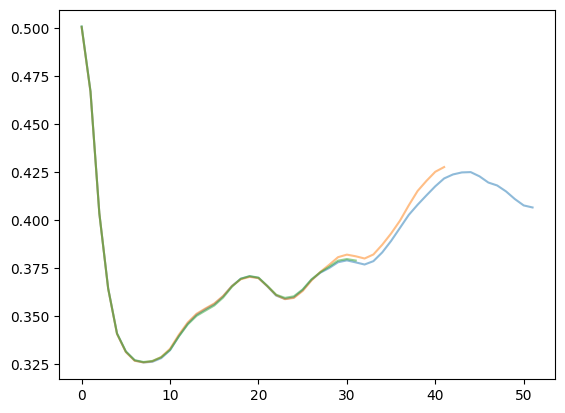

In [141]:
esn4 = ESNN(n_input=4,n_internal=10000,n_output=1,spectralRadius=3.1,inputScaling=[1,0.01,0.01,0.01],noise_level=0.0, methodWeightCompute="pseudoinverse",learningMode="Baldassarre", connectivityScale=1, network_type ="leaky",leakage=1,atime_constant=1,ltime_constant=0.75)
esn4.w_check(inputs6)



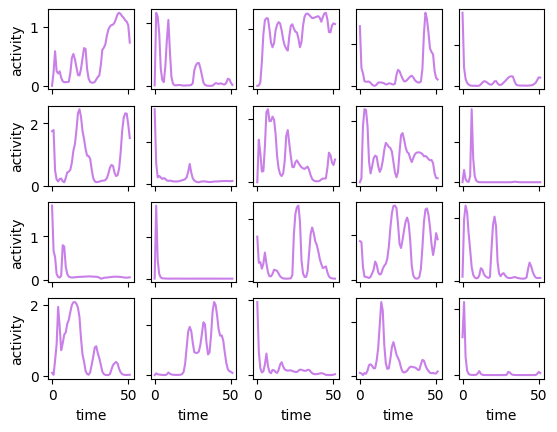

In [142]:
esn4.train(inputs6,outputs6,0)
esn4.display_units()

[0.         0.98805599 0.        ]


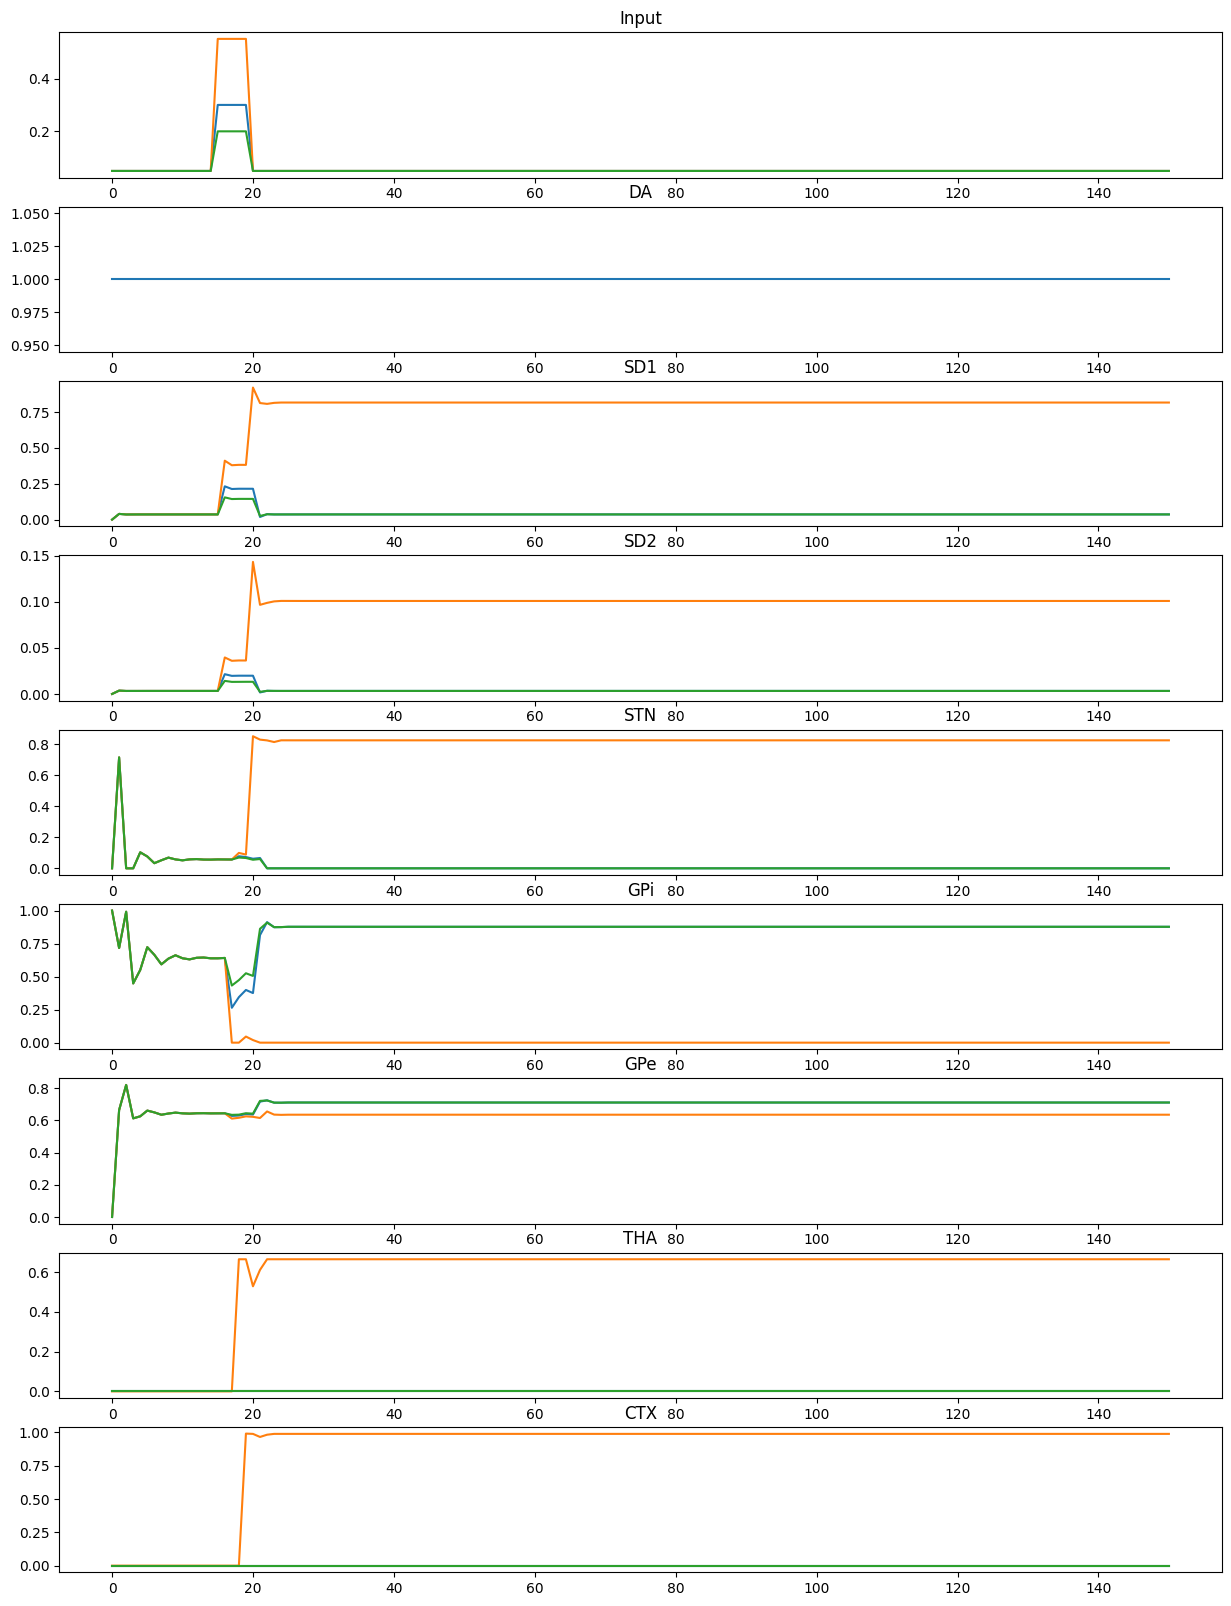

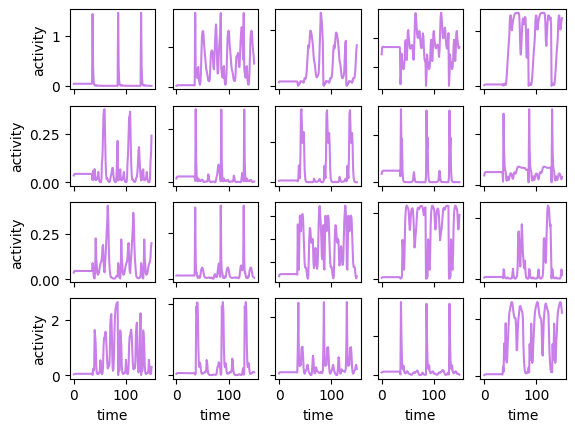

In [143]:
internal,output,input = esn4.live_run(time_points=150)
#plt.plot(output, color="red", alpha = 0.5, label = "output")
#plt.plot(input, color="blue", alpha = 0.5, label = "input")

esn4.display_units()

[[0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [1.    0.    0.988 0.   ]
 

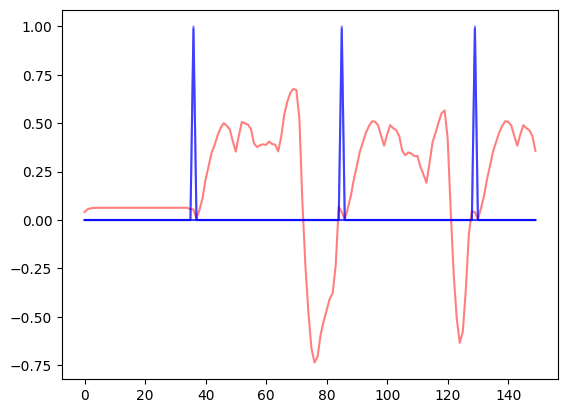

In [144]:
plt.plot(output, color="red", alpha = 0.5, label = "output")
plt.plot(input, color="blue", alpha = 0.5, label = "input")
print(input)


In [138]:
np.concatenate([[1],[1]])

array([1, 1])